<a href="https://colab.research.google.com/github/Kang-In-Seong/-/blob/main/informer%EB%A5%BC%20%EC%9D%B4%EC%9A%94%ED%95%9C%20%EB%AF%B8%EB%9E%98%20%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import sys
sys.path.append('/content/drive/MyDrive')
from utils.masking import TriangularCausalMask, ProbMask
from models.model import Informer

In [ ]:
#유틸 폴더를 제대로 인식했는지 체크
!ls /content/drive/MyDrive/utils/


__init__.py  masking.py  metrics.py  __pycache__  timefeatures.py  tools.py


In [ ]:
# standard scler 구현
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.

    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean

# 시간 특징을 freq에 따라 추출
def time_features(dates, freq='d'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    freq_map = {
        'y':[],
        'm':['month'],
        'w':['month'],
        'd':['month','day'],
        'b':['month','day','weekday']}
    return dates[freq_map[freq.lower()]].values

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y


In [ ]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe

        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='d'
        else:
            self.freq='b'

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)

        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('아비도스').sheet1

# get_all_values gives a list of rows
rows = worksheet.get_all_values()

In [ ]:
# Convert to a DataFrame and render.
import pandas as pd
data = pd.DataFrame(rows[1:], columns=rows[0])
data.head()

,time,average,value,
0,2024-07-10,87.3,"387,203",
1,2024-07-11,89.9,"2,049,593",
2,2024-07-12,86.1,"3,138,938",
3,2024-07-13,71.1,"3,054,622",
4,2024-07-14,66.9,"3,539,439",


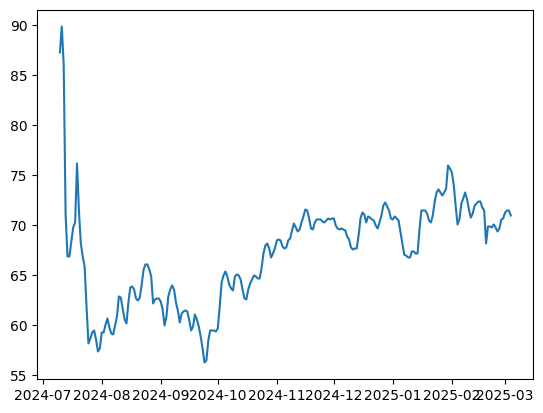

,time,average,value,
0,2024-07-10,87.3,"387,203",
1,2024-07-11,89.9,"2,049,593",
2,2024-07-12,86.1,"3,138,938",
3,2024-07-13,71.1,"3,054,622",
4,2024-07-14,66.9,"3,539,439",


In [ ]:
data['average'] = data['average'].astype(str)
data["average"] = data["average"].str.replace(',', '')
data["average"] = pd.to_numeric(data["average"], errors='coerce')
data['time'] = pd.to_datetime(data["time"], format="%Y-%m-%d")

plt.plot(data["time"], data["average"])
plt.show()
data.head()

In [ ]:
data

,time,average,value,
0,2024-07-10,87.3,"387,203",
1,2024-07-11,89.9,"2,049,593",
2,2024-07-12,86.1,"3,138,938",
3,2024-07-13,71.1,"3,054,622",
4,2024-07-14,66.9,"3,539,439",
...,...,...,...,...
233,2025-02-28,70.7,"12,979,021",
234,2025-03-01,71.3,"13,775,986",
235,2025-03-02,71.5,"12,469,587",
236,2025-03-03,71.5,"11,018,585",


In [ ]:
data["date"] = data["time"]
data["date"] = data["date"].astype(str)

# 문자열을 원하는 형식으로 슬라이스하고 변환
data["date"] = pd.to_datetime(
    data["date"].str.slice(start=0, stop=4) + "/" +
    data["date"].str.slice(start=5, stop=7) + "/" +
    data["date"].str.slice(start=8, stop=10)
)
min_max_scaler = MinMaxScaler()
data["average"] = min_max_scaler.fit_transform(data["average"].to_numpy().reshape(-1,1)).reshape(-1)
data = data[["date", "average"]]

# 마지막 일주일을 제외한 데이터를 학습 데이터로 사용
data_train = data.iloc[:-7].copy()


In [ ]:
pred_len = 7

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True

dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)


<ipython-input-38-15a07dd1e119>:23: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
<ipython-input-38-15a07dd1e119>:24: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
<ipython-input-38-15a07dd1e119>:25: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)


In [ ]:

# 데이터 크기 확인
print(data_train.shape)  # 데이터가 기대한 크기인지 확인

# seq_len, label_len, pred_len 값 확인
print("seq_len:", seq_len, "label_len:", label_len, "pred_len:", pred_len)

# 필요한 경우 파라미터 크기 줄이기
if data_train.shape[0] < seq_len + label_len + pred_len:
    print("데이터 크기를 초과하는 인덱싱입니다. 파라미터 값을 줄이세요.")

(231, 2)
seq_len: 7 label_len: 7 pred_len: 7


In [ ]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
train_epochs = 1000
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))


loss: 0.000156: 100%|██████████| 1000/1000 [13:20<00:00,  1.25it/s]


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     238 non-null    datetime64[ns]
 1   average  238 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [ ]:
scaler = dataset.scaler
df_test = data_train.copy()
df_test["average"] = scaler.transform(df_test["average"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"].iloc[1] - df_test["date"].iloc[0]
for i in range(pred_len):
    new_row = pd.DataFrame({"date": [df_test["date"].iloc[-1] + delta]})  # 새로운 행 생성
    df_test = pd.concat([df_test, new_row], ignore_index=True)  # ⬅️ append 대신 concat 사용!


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []


for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):

    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)

    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
    preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds


<ipython-input-38-15a07dd1e119>:23: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
<ipython-input-38-15a07dd1e119>:24: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
<ipython-input-38-15a07dd1e119>:25: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
<ipython-input-38-15a07dd1e119>:23: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead

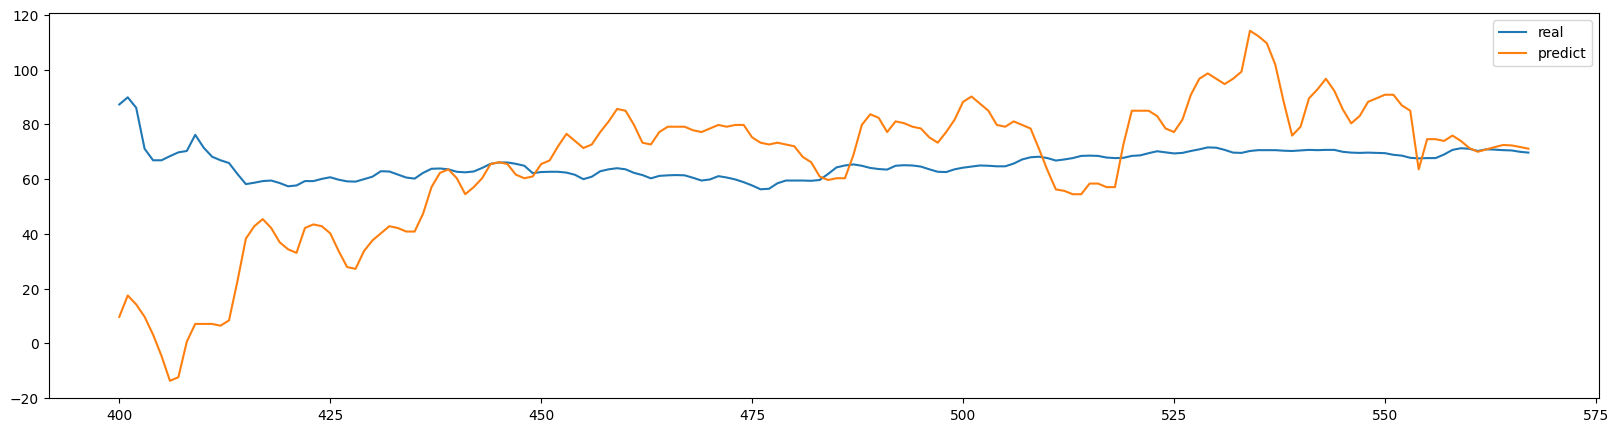

In [ ]:
import matplotlib.pyplot as plt

real = data["average"].to_numpy()
result = df_test["average"].iloc[-24*7:].to_numpy()

real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

real_values = real[400:] if len(real) > 400 else real  # 400번째 데이터가 없으면 전체 사용
predict_values = result

min_len = min(len(real_values), len(predict_values))  # 실제 데이터 크기에 맞게 조정

x_start = max(0, 400)  # 음수 방지
x_end = x_start + min_len

plt.figure(figsize=(20,5))
plt.plot(range(x_start, x_end), real_values[:min_len], label="real")
plt.plot(range(x_start, x_end), predict_values[:min_len], label="predict")
plt.legend()
plt.show()


In [ ]:
print("result shape:", result.shape)

result shape: (168,)


In [ ]:
print("df_test.shape:", df_test.tail(10))

df_test.shape:           date   average
228 2025-02-23  0.583835
229 2025-02-24  0.525883
230 2025-02-25  0.448612
231 2025-02-26  0.408000
232 2025-02-27  0.433051
233 2025-02-28  0.458597
234 2025-03-01  0.481674
235 2025-03-02  0.477167
236 2025-03-03  0.460495
237 2025-03-04  0.441550


In [ ]:
print(real.shape[0])

238
